<a href="https://colab.research.google.com/github/BlueBug12/stock/blob/master/bin/cloud/CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 3.0MB 44.7MB/s 
     |████████████████████████████████| 460kB 50.8MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
!nvidia-smi

Mon Nov 16 14:20:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Dense, Activation,MaxPooling1D, GlobalAveragePooling1D, Dropout, Lambda, RepeatVector, Input, Reshape, Flatten, LSTM
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import math

In [3]:
print(tensorflow.__version__)

2.2.0


In [4]:
def buildYTrain(train, pastDay, futureDay,profit):
    Y_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
        ave = np.mean(train['high'][i+pastDay:i+pastDay+futureDay])
        #if train['close'][i+pastDay] > train['close'][i+pastDay-1]:
        #    Y_train.append(1)
        #else:
        #    Y_train.append(0)

        if (ave-train['close'][i+pastDay-1])/ train['close'][i+pastDay-1] >= profit:
            Y_train.append(1)
        #if train['close'][i+pastDay] > train['close'][i+pastDay-1]:
        #    Y_train.append(1)
        #elif (ave-train['close'][i+pastDay])/ train['close'][i+pastDay] < -profit:
        #    Y_train.append(1)
        else:
            Y_train.append(0)     
    return np.array(Y_train)

def buildXTrain(train, pastDay, futureDay,profit):
    X_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
    return np.array(X_train)

def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)

    return normalize_data
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Losss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [5]:
from google.colab import files
uploaded = files.upload()

Saving 2330.pickle to 2330.pickle
Saving 2603.pickle to 2603.pickle
Saving 2610.pickle to 2610.pickle


In [ ]:
!mv 2610.pickle data/

In [ ]:
!mkdir data
!mv 2610.pickle data/

In [6]:
with open(os.path.join(os.getcwd(),"2610.pickle"),'rb') as f:
    df = pickle.load(f)
    print(df.tail())
    print(df.shape)
    df.drop(['year','week','month','day','adj_close'],axis=1,inplace=True)
    
    '''
    df = df[['open','high','low','close','volume']]
    '''
    df['diff1'] = df['close']-df['open']
    df['diff2']= df['close']-df['low']
    df['diff3']= df['high']-df['close']
    df['diff4']= df['high']-df['low']
    df['diff5']= df['open']-df['low']
    df['diff5']= df['high']-df['open']
    #df = df[['open','high','low','close','volume']]
    
    

    

      adj_close  close  high   low  ...     ema_D        RS        RSI       OBV
4082       8.32   8.32  8.39  8.20  ...  0.071174  0.336450  25.174926  0.631579
4083       8.40   8.41  8.48  8.29  ...  0.061684  0.530991  34.682835  0.631579
4084       9.09   9.10  9.18  8.80  ...  0.066331  1.834249  64.717285  0.789474
4085       9.01   9.01  9.19  8.97  ...  0.069487  1.517486  60.277827  0.181818
4086       8.88   8.88  9.04  8.80  ...  0.077556  1.178334  54.093359  0.333333

[5 rows x 36 columns]
(4087, 36)


In [7]:
past = 60
future = 5
profit = 0.02
val_ratio = 0.2
sample = 100

data_y = buildYTrain(df.copy(),past,future,profit)

#df = df.copy().drop(['open','high','low','close'],axis=1)
df = df.copy()
data = normalize_data(df.copy())

data_x = buildXTrain(data,past,future,profit)
print(data_x.shape)
print(data_y.shape)



(4022, 60, 36)
(4022,)


In [8]:
data_X, data_Y = shuffle(data_x, data_y)
x_train, y_train, x_val, y_val = splitData(data_X, data_Y, val_ratio)
test_x = x_train[-sample:]
x_train = x_train[:-sample]
test_y = y_train[-sample:]
y_train = y_train[:-sample]
#Y_train = to_categorical(y_train, num_classes=num_classes)
#Y_val = to_categorical(y_val, num_classes=num_classes)

In [9]:
print(test_y)

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]


In [93]:
backend.clear_session()

model = Sequential()
model.add(LSTM(units = 16,  input_shape = (x_train.shape[1:]), return_sequences=True,activation='selu'))
model.add(Dropout(0.2))
model.add(LSTM(units = 16, return_sequences=True,activation='selu'))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, activation='selu'))
model.add(Conv1D(32, 3, activation='selu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='selu'))
model.add(Conv1D(32, 3, activation='selu'))
model.add(MaxPooling1D(2))

#model.add(LSTM(units = 32,activation='selu'))
#model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(32, activation='selu'))    
model.add(Dropout(0.2))    
model.add(Dense(32, activation='selu'))    
model.add(Dropout(0.2)) 

#model.add(Dense(units = 1, activation='relu'))


# (b, 128, 30) > (b, 128, 1) > (b, 128)
# (b, 128) > (b, 1)

#model.add(Dense(units = 24))
#model.add(Dropout(0.5))
model.add(Dense(units = 1, activation='sigmoid'))

op=tensorflow.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)
model.compile(loss='binary_crossentropy', optimizer=op, metrics=['accuracy'])

'''
model = Sequential()
model.add(Conv1D(16, 3, activation='selu', input_shape=(x_train.shape[1:])))
model.add(Conv1D(16, 3, activation='selu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(16, 3, activation='selu'))
model.add(Conv1D(16, 3, activation='selu'))
model.add(MaxPooling1D(2))

model.add(Conv1D(16, 3, activation='selu'))
model.add(Conv1D(16, 3, activation='selu'))
model.add(MaxPooling1D(2))

model.add(Conv1D(16, 3, activation='selu'))
model.add(Conv1D(16, 3, activation='selu'))
model.add(MaxPooling1D(2))


#model.add(Conv1D(128, 3, activation='selu'))
#model.add(Conv1D(128, 3, activation='selu'))

#model.add(Conv1D(160, 3, activation='selu'))
#model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='selu'))    
model.add(Dropout(0.5))    
model.add(Dense(512, activation='selu'))    
model.add(Dropout(0.5)) 
#model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
'''


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 16)            3392      
_________________________________________________________________
dropout (Dropout)            (None, 60, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 16)            2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 58, 32)            1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 32)            0

Epoch 1/1000
98/98 [==============================] - 17s 174ms/step - loss: 0.6762 - accuracy: 0.6693 - val_loss: 0.5846 - val_accuracy: 0.7177
Epoch 2/1000
98/98 [==============================] - 17s 170ms/step - loss: 0.6117 - accuracy: 0.6937 - val_loss: 0.6142 - val_accuracy: 0.6679
Epoch 3/1000
98/98 [==============================] - 17s 170ms/step - loss: 0.5929 - accuracy: 0.7017 - val_loss: 0.6287 - val_accuracy: 0.6729
Epoch 4/1000
98/98 [==============================] - 17s 169ms/step - loss: 0.5858 - accuracy: 0.7126 - val_loss: 0.6364 - val_accuracy: 0.6866
Epoch 5/1000
98/98 [==============================] - 17s 169ms/step - loss: 0.5806 - accuracy: 0.7101 - val_loss: 0.5658 - val_accuracy: 0.7189
Epoch 6/1000
98/98 [==============================] - 17s 169ms/step - loss: 0.5769 - accuracy: 0.7158 - val_loss: 0.5558 - val_accuracy: 0.7338
Epoch 7/1000
98/98 [==============================] - 16s 168ms/step - loss: 0.5718 - accuracy: 0.7168 - val_loss: 0.5816 - val_ac

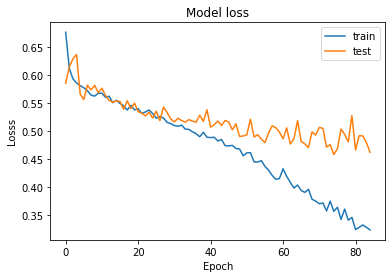

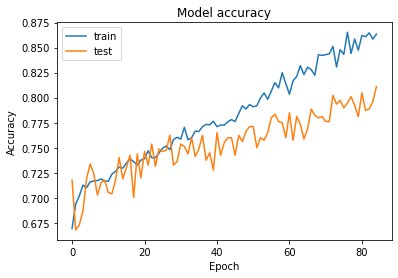

In [94]:
callback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
history=model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_val, y_val), callbacks=[callback])
training_result(history)

In [95]:
ans=model.predict(test_x)
TP = 0
FP = 0
TN = 0
FN = 0
thre = 0.5

for i in range(len(test_y)):
  if (ans[i]>=thre and test_y[i]>0.5):
    TP += 1
  elif (ans[i]>=thre and test_y[i]<0.5):
    FP += 1
  elif (ans[i]<thre and test_y[i]>0.5):
    FN += 1
  else:
    TN += 1
t = 0
f = 0
for i in range(len(test_y)):
  if test_y[i]>0.5:
    t+=1
  else:
    f+=1

print(f'TP:{TP}',f'FP:{FP}',f'TN:{TN}',f'FN:{FN}')
print(TP/(TP+FP))
print(t,f)

TP:15 FP:5 TN:64 FN:16
0.75
31 69


In [53]:
ans

array([[0.51515657],
       [0.05201308],
       [0.05881078],
       [0.5030589 ],
       [0.2598351 ],
       [0.17997016],
       [0.22417589],
       [0.84754217],
       [0.17408118],
       [0.2917655 ],
       [0.34872788],
       [0.03139626],
       [0.46634758],
       [0.11042711],
       [0.66015434],
       [0.9560649 ],
       [0.05079189],
       [0.03463334],
       [0.14784692],
       [0.67778975],
       [0.677145  ],
       [0.04058213],
       [0.12556632],
       [0.30733287],
       [0.60952765],
       [0.8958636 ],
       [0.66759133],
       [0.4619913 ],
       [0.96760935],
       [0.06241743],
       [0.7518124 ],
       [0.32792568],
       [0.51531357],
       [0.43576017],
       [0.6975855 ],
       [0.15927747],
       [0.8605646 ],
       [0.1447404 ],
       [0.06337319],
       [0.08064128],
       [0.63706225],
       [0.05180239],
       [0.37459868],
       [0.15624832],
       [0.0831103 ],
       [0.14897802],
       [0.12742977],
       [0.610